In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


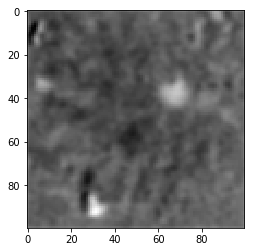

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'lisa_05' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 2000
l1_coeff = 0.1
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


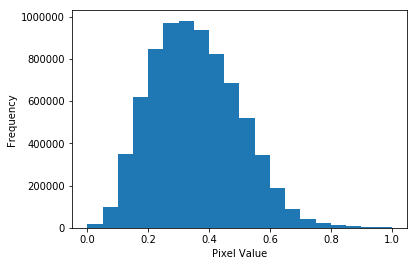

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#normalizing 
# coords /= (IMG_SIZE-1)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


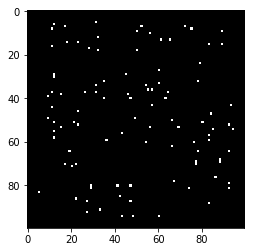

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord=tf.pad(inps, paddings, "REFLECT")
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    act1=tf.keras.layers.ReLU()(coord1)
    pool1=MaxPooling2D((2, 2), strides=2,padding='same')(act1)
    
    #conv block2
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord3=tf.pad(pool1, paddings2, "REFLECT")
    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coord3)
    pool2=MaxPooling2D((2, 2), strides=2,padding='same')(conv1)
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord5=tf.pad(pool2, paddings4, "REFLECT")
    x = Conv2D(128, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x = UpSampling2D(size=(2, 2))(x)
    paddings5 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings5, "REFLECT")
    x = Conv2D(64, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(x)
    x = UpSampling2D(size=(2,2))(x)
    paddings6 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings6, "REFLECT")
    x = Conv2D(16, 3, padding = 'valid', activation = 'relu')(x)
    paddings7 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings7, "REFLECT")
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid',activity_regularizer=l1(0.1))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = bxent(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = bxent(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #multiply similarity scores with one hot images
            #(batch_size, n_neurons, img_size, img_size,1)
            similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) 
            similarity_multi_dummy = tf.einsum('ij,jklm->ijklm', similarity_score, dummy_one_hot) 
            #(batch_size, img_size, img_size, 1)
            similarity_multi_reduced_neurons = tf.reduce_sum(similarity_multi, axis=1)
            similarity_multi_reduced_dummy = tf.reduce_sum(similarity_multi_dummy, axis=1)
            if one_hot_thr==True:
                #threshold multiplied similarity scores with one hot images
                similarity_multi_threshold = tf.where(similarity_multi_reduced_neurons<0.7, 0.0, 
                                                      similarity_multi_reduced_neurons)
                similarity_multi_threshold_dummy  = tf.where(similarity_multi_reduced_dummy<0.7, 
                                                             0.0, similarity_multi_reduced_dummy)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            elif one_hot_thr==False: 
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

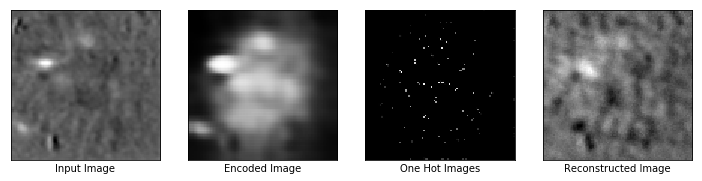

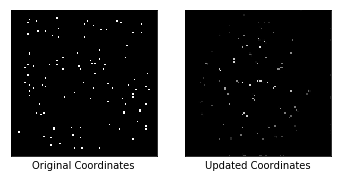

Epochs: 100, Reconstruction Loss: 0.0024548331275582314
Regularizer Loss: 15761.7373046875, Total Loss: 15761.740234375
Encoder Loss: 5.8199591636657715
Max Similarity scores: 0.8681352138519287
Updated Coordinates: [[[0.33634195 0.33305627]]]
Gradient global min:-0.000461096060462296, max:0.00041656073881313205
Gradient encoder min:-1.2017955780029297, max:2.645291566848755
Gradient learnable coords min:-4.131934110773727e-05, max:5.848295768373646e-05



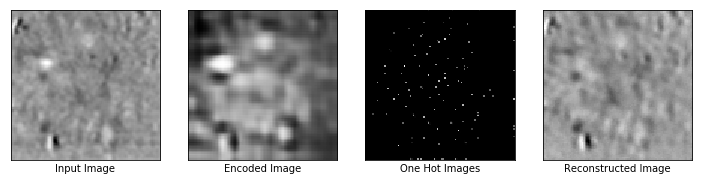

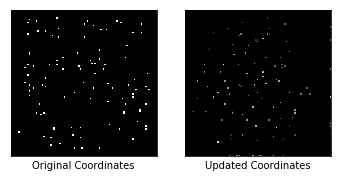

Epochs: 200, Reconstruction Loss: 0.001715651131235063
Regularizer Loss: 15752.9912109375, Total Loss: 15752.9931640625
Encoder Loss: 3.950536012649536
Max Similarity scores: 0.9471557140350342
Updated Coordinates: [[[0.33340818 0.30238673]]]
Gradient global min:-0.001954714534804225, max:0.002686653286218643
Gradient encoder min:-0.9951185584068298, max:1.932868242263794
Gradient learnable coords min:-1.2858346053690184e-05, max:2.1040148567408323e-05



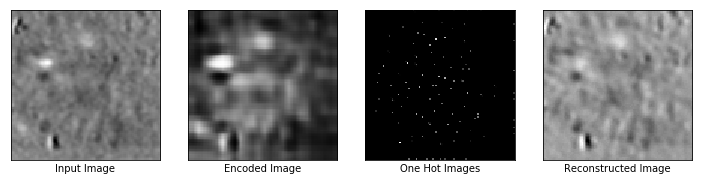

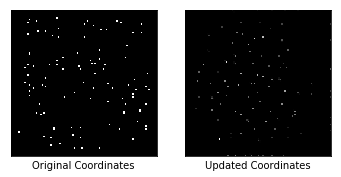

Epochs: 300, Reconstruction Loss: 0.0011811581207439303
Regularizer Loss: 14589.9755859375, Total Loss: 14589.9765625
Encoder Loss: 3.686612129211426
Max Similarity scores: 0.8566111922264099
Updated Coordinates: [[[0.340592   0.31281006]]]
Gradient global min:-0.0010619245003908873, max:0.0010638994863256812
Gradient encoder min:-1.0883841514587402, max:1.5730299949645996
Gradient learnable coords min:-1.3385521924647037e-05, max:2.0950463294866495e-05



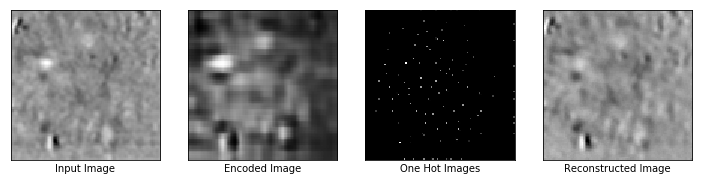

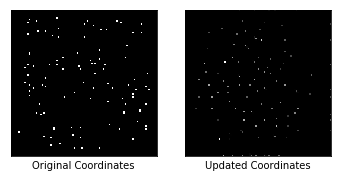

Epochs: 400, Reconstruction Loss: 0.0009983793133869767
Regularizer Loss: 12957.0791015625, Total Loss: 12957.080078125
Encoder Loss: 3.0669076442718506
Max Similarity scores: 0.8538679480552673
Updated Coordinates: [[[0.32229558 0.32149336]]]
Gradient global min:-0.0002199784794356674, max:0.00030868645990267396
Gradient encoder min:-1.0238523483276367, max:1.3448832035064697
Gradient learnable coords min:-2.272325218655169e-05, max:2.729401558099198e-06



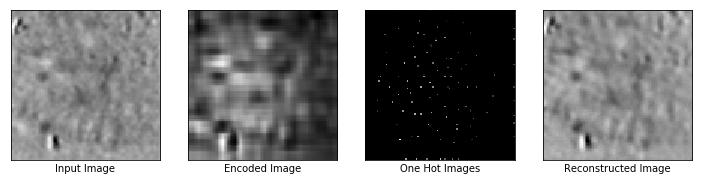

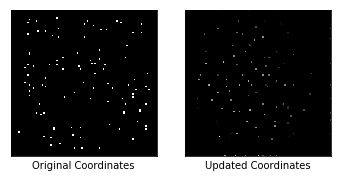

Epochs: 500, Reconstruction Loss: 0.0015190368285402656
Regularizer Loss: 11363.0625, Total Loss: 11363.064453125
Encoder Loss: 2.7260286808013916
Max Similarity scores: 0.7912392616271973
Updated Coordinates: [[[0.33273438 0.31184232]]]
Gradient global min:-0.004995557013899088, max:0.003487246111035347
Gradient encoder min:-1.031213641166687, max:1.1626667976379395
Gradient learnable coords min:-0.00010801437019836158, max:3.788460890064016e-05



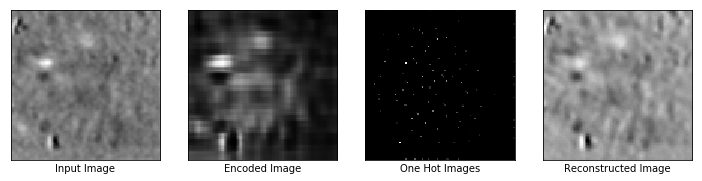

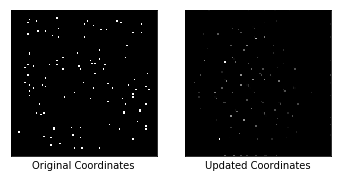

Epochs: 600, Reconstruction Loss: 0.0009063670877367258
Regularizer Loss: 10815.0732421875, Total Loss: 10815.07421875
Encoder Loss: 2.062304735183716
Max Similarity scores: 0.7309002876281738
Updated Coordinates: [[[0.32743338 0.32777393]]]
Gradient global min:-0.0010504183592274785, max:0.0018835302907973528
Gradient encoder min:-0.8805031180381775, max:0.883400022983551
Gradient learnable coords min:-1.6537003830308095e-05, max:3.396362080820836e-05



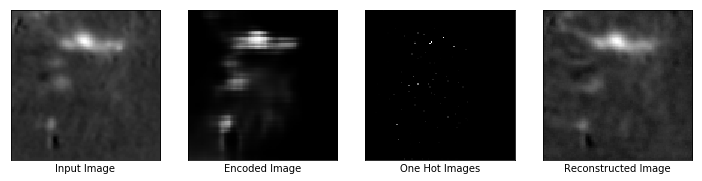

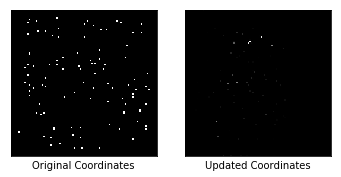

Epochs: 700, Reconstruction Loss: 0.001155760372057557
Regularizer Loss: 10865.623046875, Total Loss: 10865.6240234375
Encoder Loss: 1.9261771440505981
Max Similarity scores: 0.7063409686088562
Updated Coordinates: [[[0.35347283 0.3233719 ]]]
Gradient global min:-0.002361807506531477, max:0.002261937828734517
Gradient encoder min:-0.8926298022270203, max:0.9409589171409607
Gradient learnable coords min:-8.851009624777362e-06, max:1.8003056538873352e-05



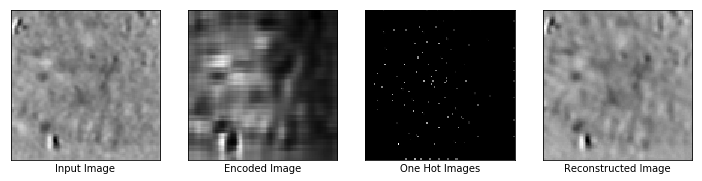

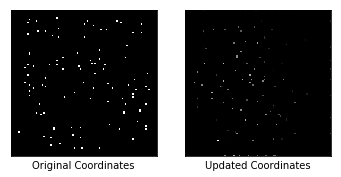

Epochs: 800, Reconstruction Loss: 0.0008509333711117506
Regularizer Loss: 11194.505859375, Total Loss: 11194.5068359375
Encoder Loss: 1.8454641103744507
Max Similarity scores: 0.6193764209747314
Updated Coordinates: [[[0.35279462 0.32148516]]]
Gradient global min:-0.0005332966102287173, max:0.001762826694175601
Gradient encoder min:-0.9248678684234619, max:0.9611520767211914
Gradient learnable coords min:-1.9762048395932652e-05, max:1.3759405192104168e-05



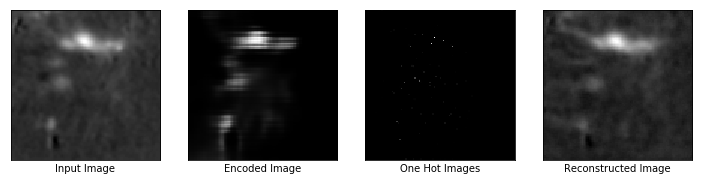

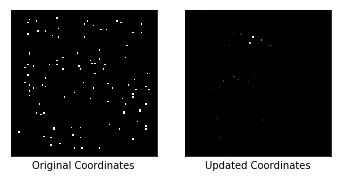

Epochs: 900, Reconstruction Loss: 0.0009901027660816908
Regularizer Loss: 11844.0380859375, Total Loss: 11844.0390625
Encoder Loss: 1.750218391418457
Max Similarity scores: 0.8187288641929626
Updated Coordinates: [[[0.3435251  0.32325736]]]
Gradient global min:-0.003256715601310134, max:0.003962981514632702
Gradient encoder min:-0.8244072794914246, max:0.8346128463745117
Gradient learnable coords min:-1.7585007299203426e-05, max:9.460494038648903e-05



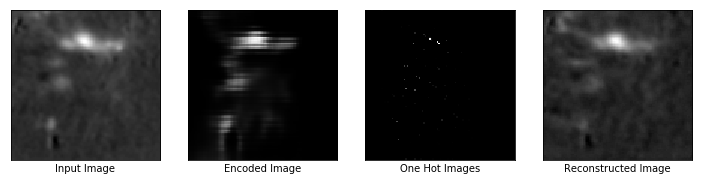

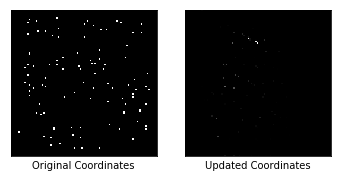

Epochs: 1000, Reconstruction Loss: 0.0009145276853814721
Regularizer Loss: 12383.544921875, Total Loss: 12383.5458984375
Encoder Loss: 1.7400926351547241
Max Similarity scores: 0.7755394577980042
Updated Coordinates: [[[0.34499842 0.3252222 ]]]
Gradient global min:-0.0005944934673607349, max:0.0007919298950582743
Gradient encoder min:-0.7946177124977112, max:0.8361842036247253
Gradient learnable coords min:-2.415129893051926e-05, max:3.774118886212818e-05



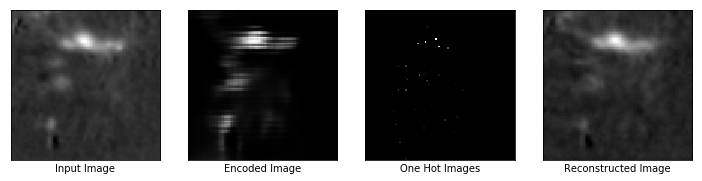

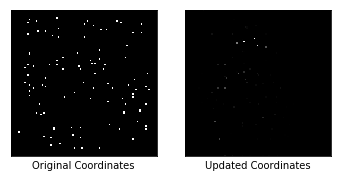

Epochs: 1100, Reconstruction Loss: 0.0008564037270843983
Regularizer Loss: 13793.47265625, Total Loss: 13793.4736328125
Encoder Loss: 1.7642457485198975
Max Similarity scores: 0.7312579154968262
Updated Coordinates: [[[0.32321143 0.3230588 ]]]
Gradient global min:-0.0016554129542782903, max:0.001604969147592783
Gradient encoder min:-0.7671987414360046, max:0.7776888012886047
Gradient learnable coords min:-5.531985152629204e-05, max:2.9995548175065778e-05



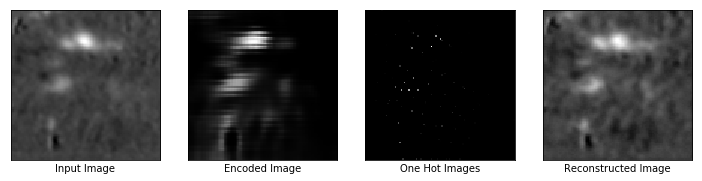

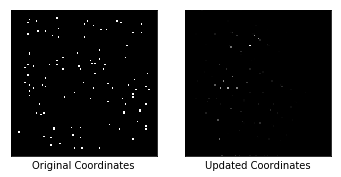

Epochs: 1200, Reconstruction Loss: 0.0009348738822154701
Regularizer Loss: 14969.4609375, Total Loss: 14969.4619140625
Encoder Loss: 1.8250439167022705
Max Similarity scores: 0.7005018591880798
Updated Coordinates: [[[0.38384277 0.30314708]]]
Gradient global min:-0.002840907545760274, max:0.002696720417588949
Gradient encoder min:-0.7369374632835388, max:0.771602213382721
Gradient learnable coords min:-4.204170181765221e-05, max:3.4464737836970016e-05



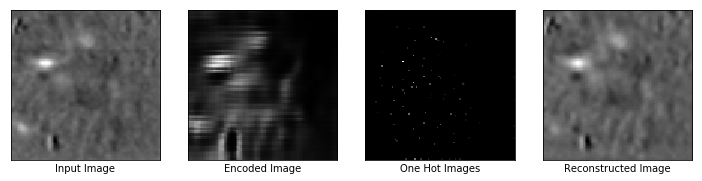

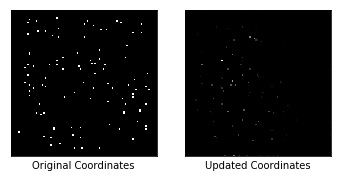

Epochs: 1300, Reconstruction Loss: 0.0013800904853269458
Regularizer Loss: 15224.3583984375, Total Loss: 15224.359375
Encoder Loss: 1.7761648893356323
Max Similarity scores: 0.6996904015541077
Updated Coordinates: [[[0.3255677  0.30677852]]]
Gradient global min:-0.0060456739738583565, max:0.0033168350346386433
Gradient encoder min:-0.6709566712379456, max:0.7588877081871033
Gradient learnable coords min:-0.0002169055223930627, max:0.0009072758839465678



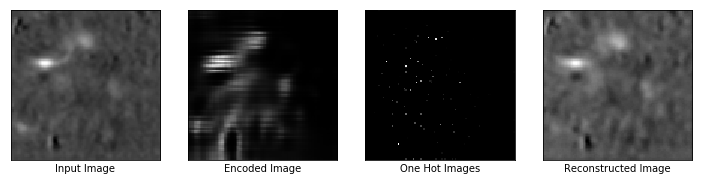

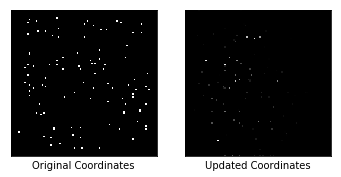

Epochs: 1400, Reconstruction Loss: 0.0007413228740915656
Regularizer Loss: 15658.498046875, Total Loss: 15658.4990234375
Encoder Loss: 1.6178267002105713
Max Similarity scores: 0.3808082938194275
Updated Coordinates: [[[0.27467927 0.41347298]]]
Gradient global min:-0.0004301445442251861, max:0.0002731296990532428
Gradient encoder min:-0.6199080348014832, max:0.6008593440055847
Gradient learnable coords min:-9.668577695265412e-05, max:0.00015357420488726348



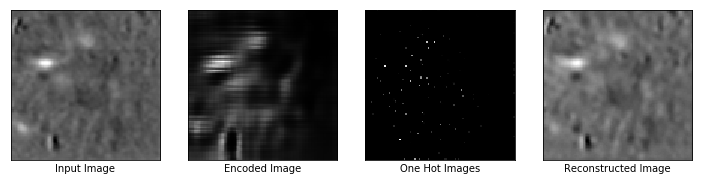

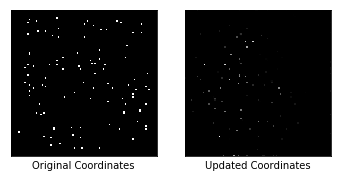

Epochs: 1500, Reconstruction Loss: 0.0007675876840949059
Regularizer Loss: 15316.3515625, Total Loss: 15316.3525390625
Encoder Loss: 1.5038225650787354
Max Similarity scores: 0.40519919991493225
Updated Coordinates: [[[0.37389007 0.33314884]]]
Gradient global min:-0.00047941802768036723, max:0.0002551160869188607
Gradient encoder min:-0.5799120664596558, max:0.5691148638725281
Gradient learnable coords min:-4.232234277878888e-05, max:2.37209205806721e-05



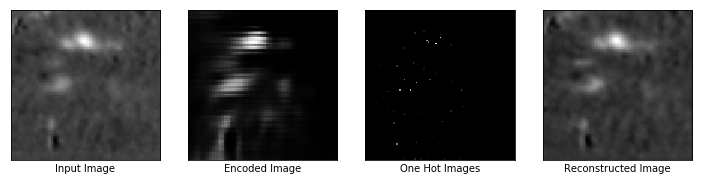

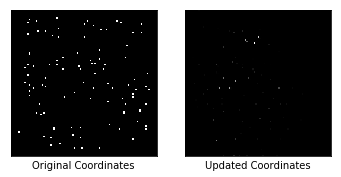

Epochs: 1600, Reconstruction Loss: 0.0006979327881708741
Regularizer Loss: 17040.025390625, Total Loss: 17040.025390625
Encoder Loss: 1.5528589487075806
Max Similarity scores: 0.6306781768798828
Updated Coordinates: [[[0.35378754 0.3643969 ]]]
Gradient global min:-0.0017650750232860446, max:0.002083742758259177
Gradient encoder min:-0.5585708618164062, max:0.570695698261261
Gradient learnable coords min:-2.4487120754201896e-05, max:6.330215001071338e-06



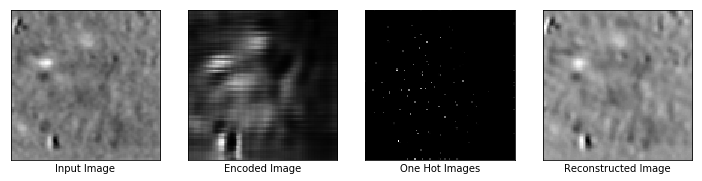

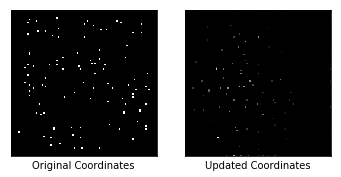

Epochs: 1700, Reconstruction Loss: 0.0008043798734433949
Regularizer Loss: 18278.8828125, Total Loss: 18278.8828125
Encoder Loss: 1.3637027740478516
Max Similarity scores: 0.6143884062767029
Updated Coordinates: [[[0.32343924 0.3636992 ]]]
Gradient global min:-0.0011898571392521262, max:0.002680994803085923
Gradient encoder min:-0.4971649944782257, max:0.5177745819091797
Gradient learnable coords min:-4.1200954001396894e-05, max:9.091458196053281e-06



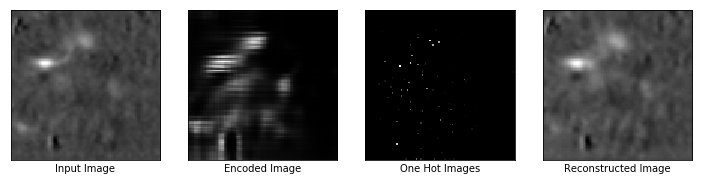

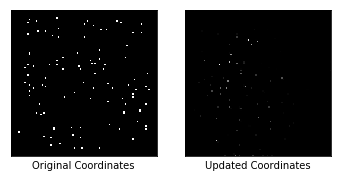

Epochs: 1800, Reconstruction Loss: 0.0006633131997659802
Regularizer Loss: 19428.939453125, Total Loss: 19428.939453125
Encoder Loss: 1.415727972984314
Max Similarity scores: 0.3700824975967407
Updated Coordinates: [[[0.35652038 0.3664853 ]]]
Gradient global min:-0.0027390506584197283, max:0.002353253308683634
Gradient encoder min:-0.4695682227611542, max:0.5720238089561462
Gradient learnable coords min:-4.674138835980557e-06, max:1.7249505617655814e-05



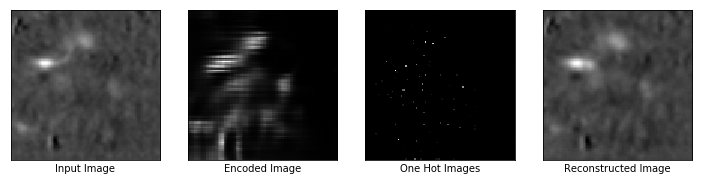

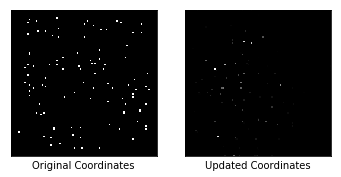

Epochs: 1900, Reconstruction Loss: 0.0006742975092492998
Regularizer Loss: 20589.19921875, Total Loss: 20589.19921875
Encoder Loss: 1.4130092859268188
Max Similarity scores: 0.40495190024375916
Updated Coordinates: [[[0.34380248 0.3636725 ]]]
Gradient global min:-0.0009074565023183823, max:0.0007147241267375648
Gradient encoder min:-0.4653753340244293, max:0.7235063314437866
Gradient learnable coords min:-1.885967685666401e-05, max:2.5660143364802934e-05



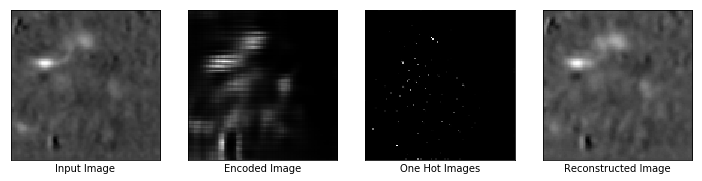

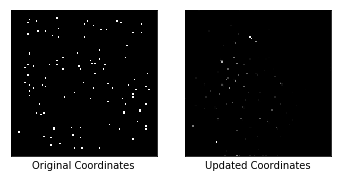

Epochs: 2000, Reconstruction Loss: 0.0007073199958540499
Regularizer Loss: 23043.7109375, Total Loss: 23043.7109375
Encoder Loss: 1.5224146842956543
Max Similarity scores: 0.4494548439979553
Updated Coordinates: [[[0.3542498  0.36398274]]]
Gradient global min:-0.0015468007186427712, max:0.0017684922786429524
Gradient encoder min:-0.4623441994190216, max:0.8429354429244995
Gradient learnable coords min:-8.804446406429633e-05, max:0.00026652414817363024


In [12]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                              IMG_SIZE, BATCH_SIZE,
                                                                                                              neuron_multi = True,
                                                                                                             one_hot_thr = True)
                                                                                                             
                                                                                                        
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    
    #note for loss indices
    #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
        print("Encoder Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
        print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
        #append to list 
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

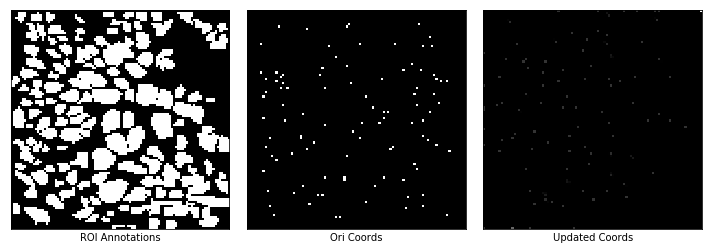

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.020000001
Counts:  196


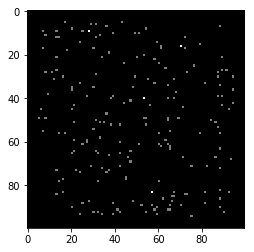

In [21]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

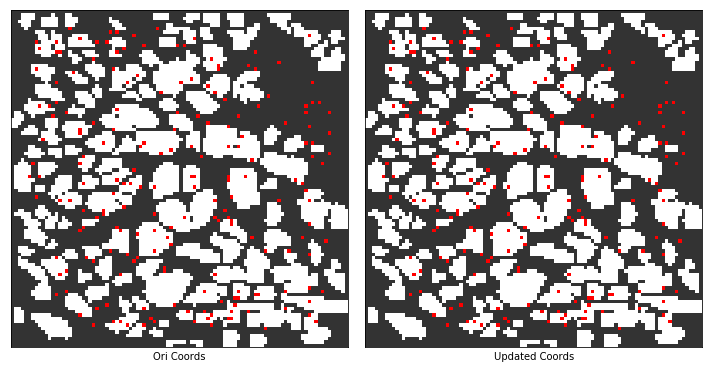

In [22]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [23]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0102
True Negatives:  0.0094
False Positive Ratio:  0.4084
False Negatives Ratio:  0.5720000000000001
F1 score:  0.04655408489274305


---

# Similarity Scores with Threshold

In [26]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

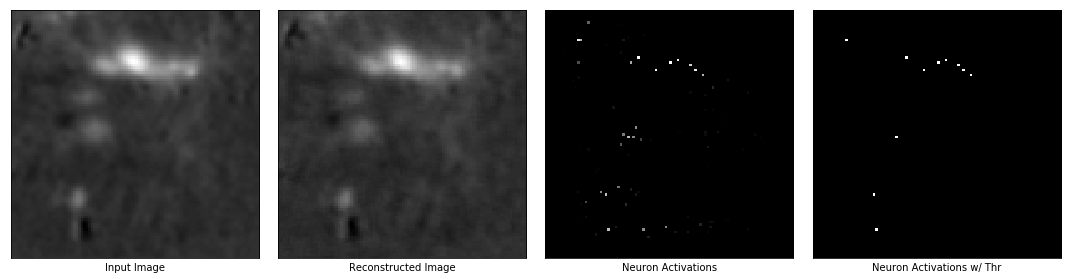

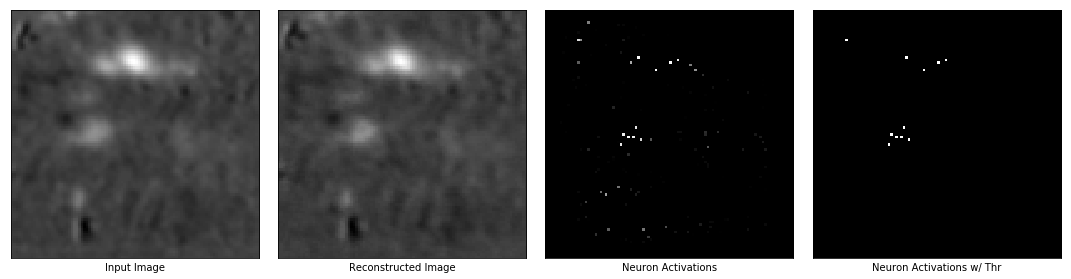

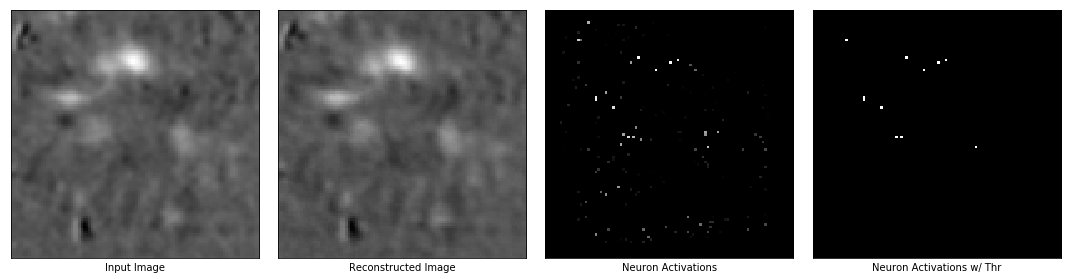

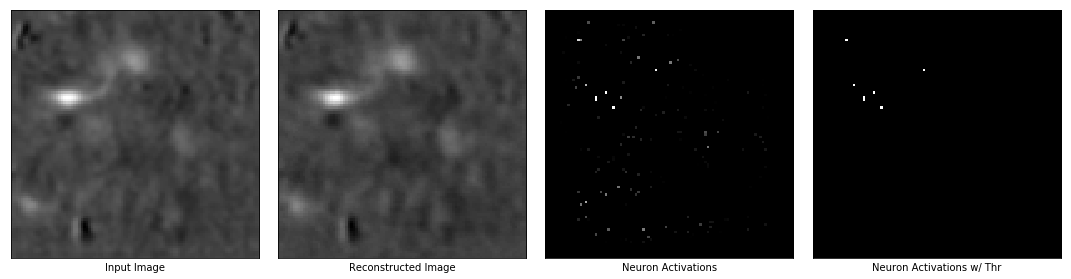

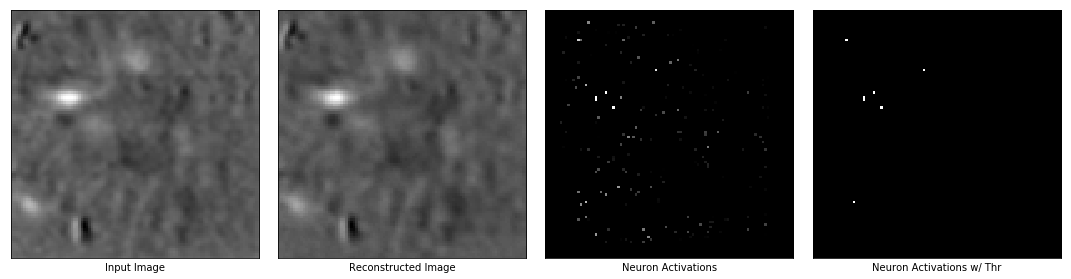

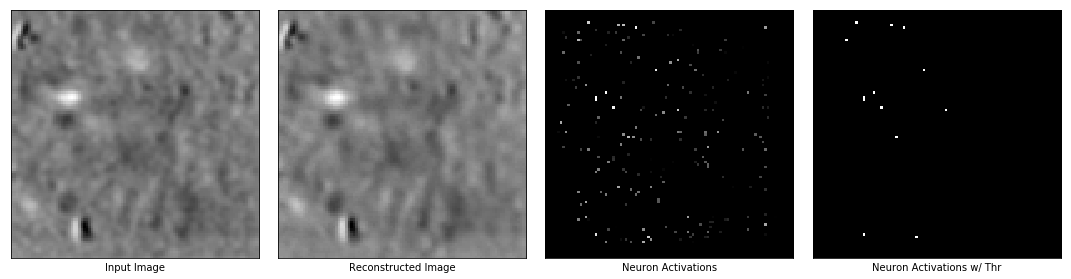

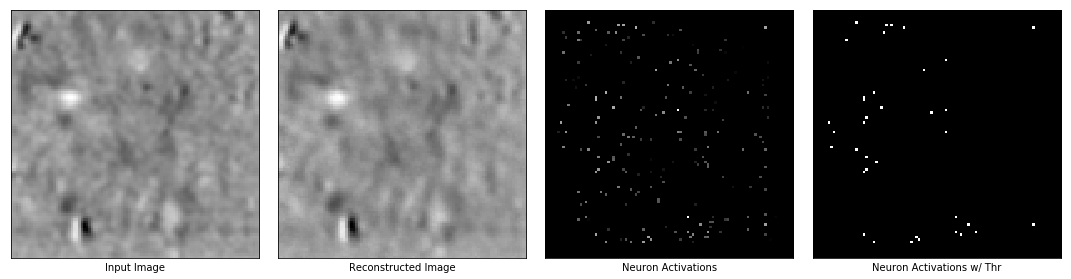

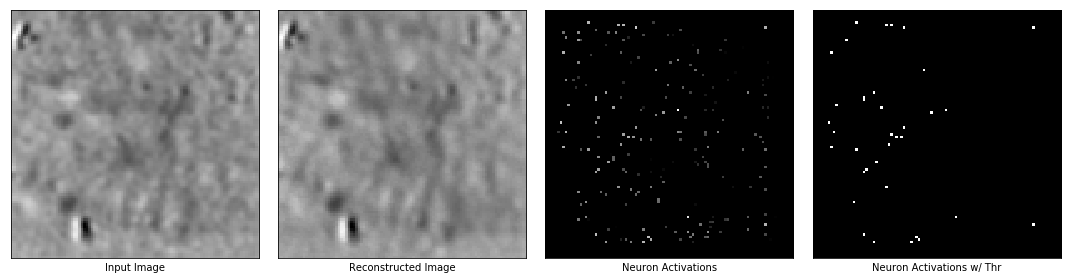

In [27]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

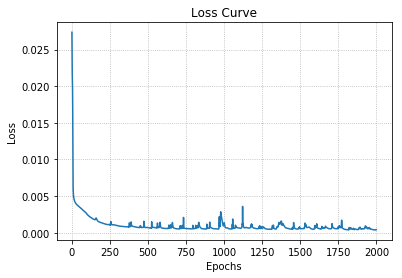

In [28]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [29]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [30]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_8
coord_conv_9
activation_2
up_sampling2d_9
conv2d_36
activation_3
conv2d_37


In [31]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


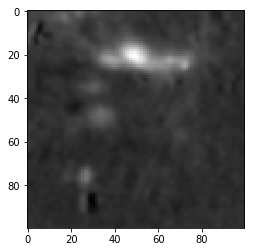

In [32]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


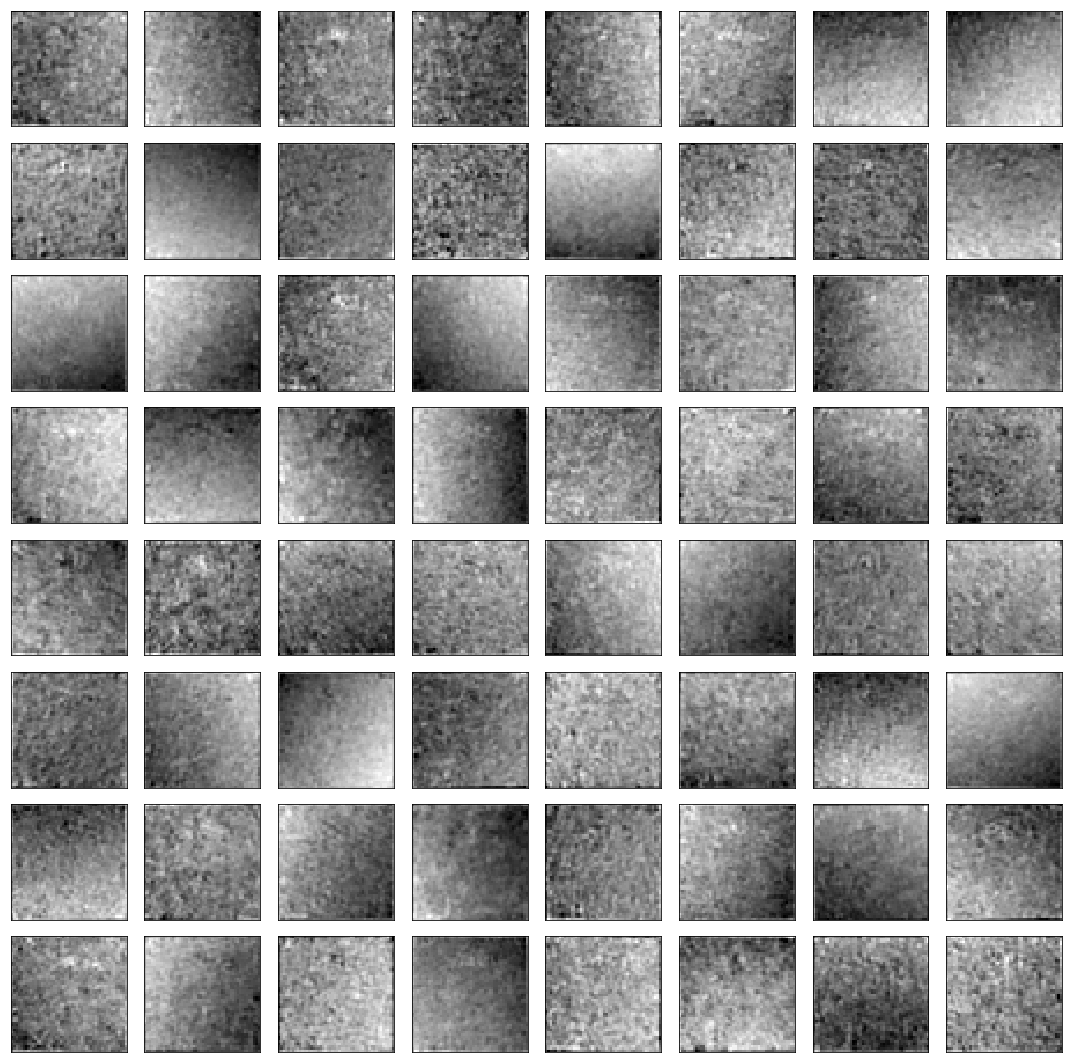

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


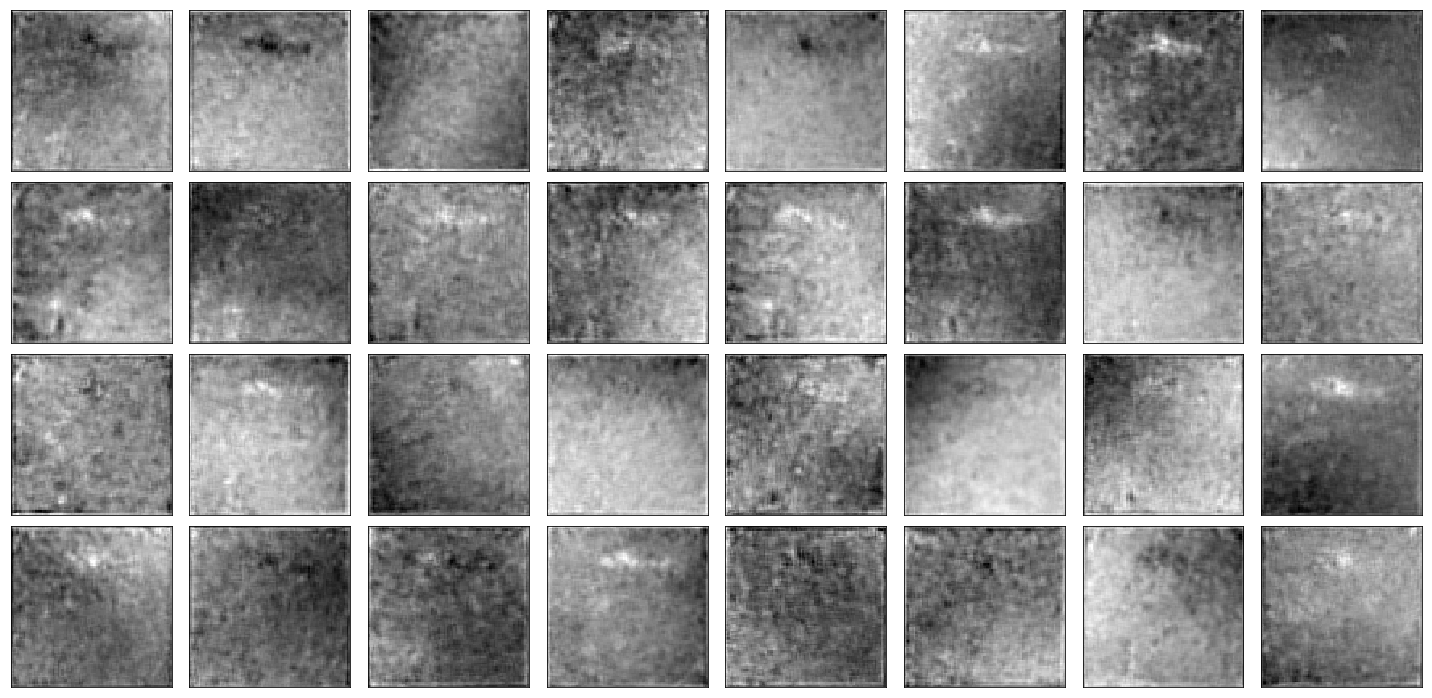

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

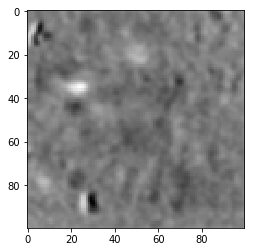

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


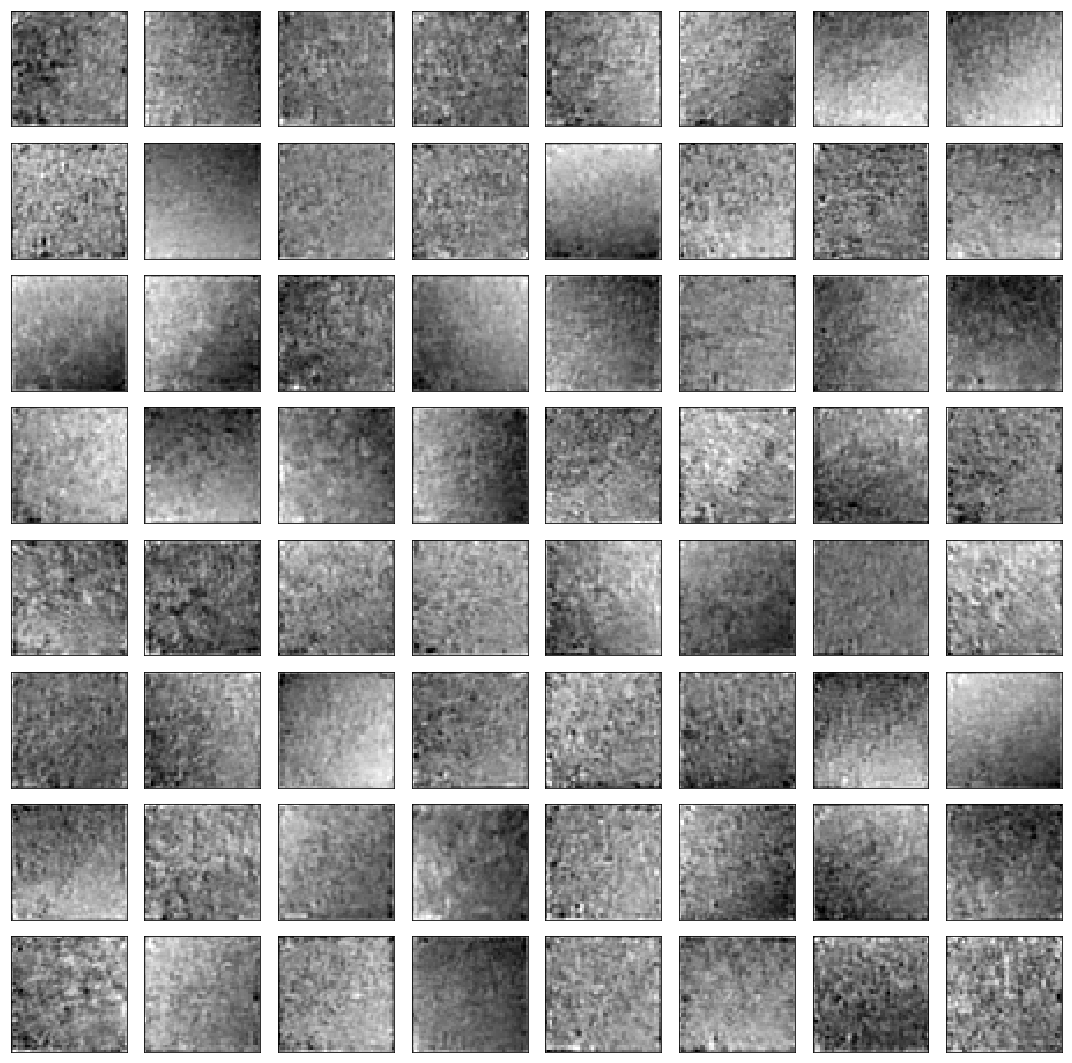

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


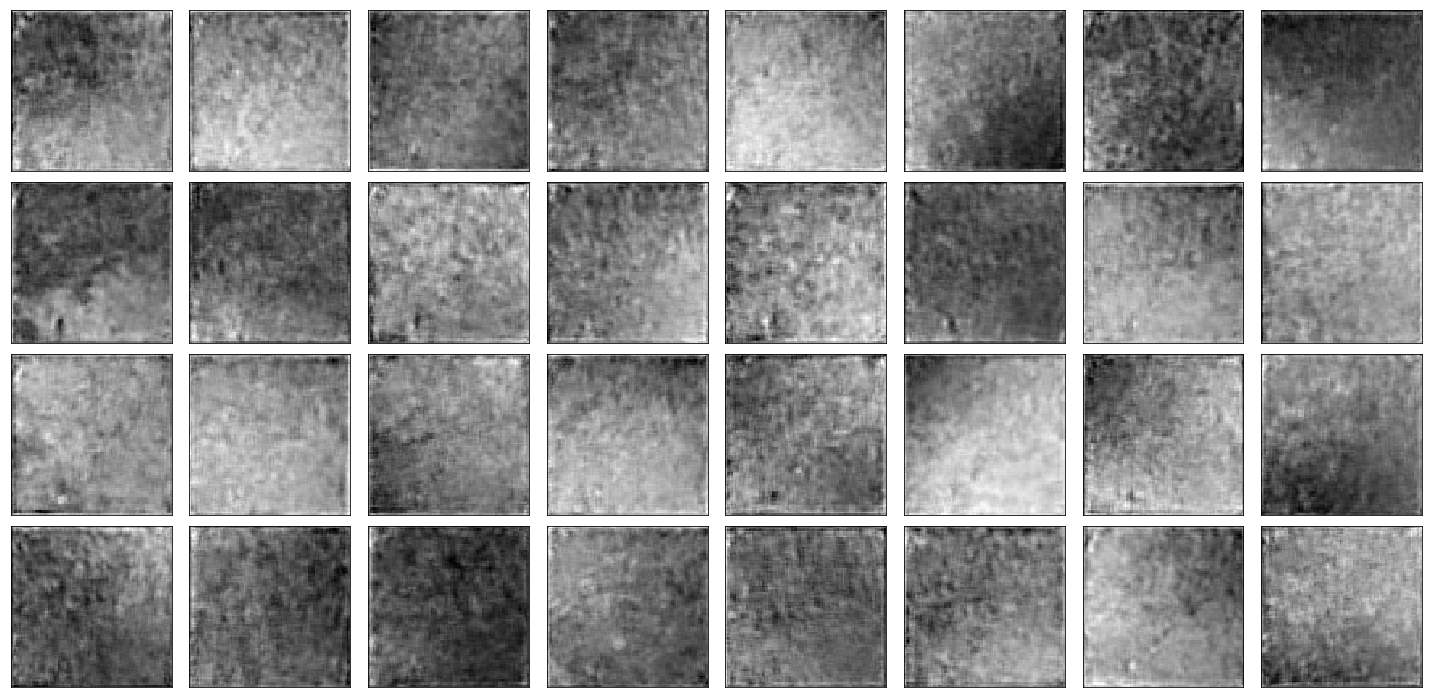

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

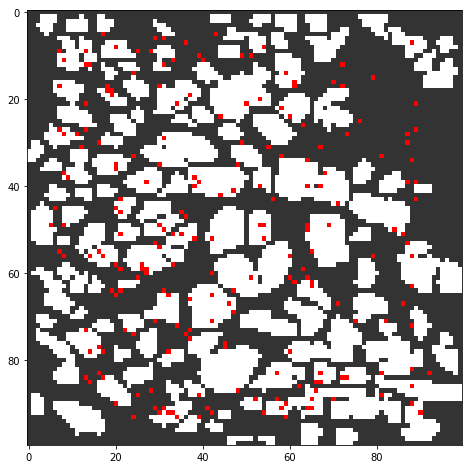

In [42]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

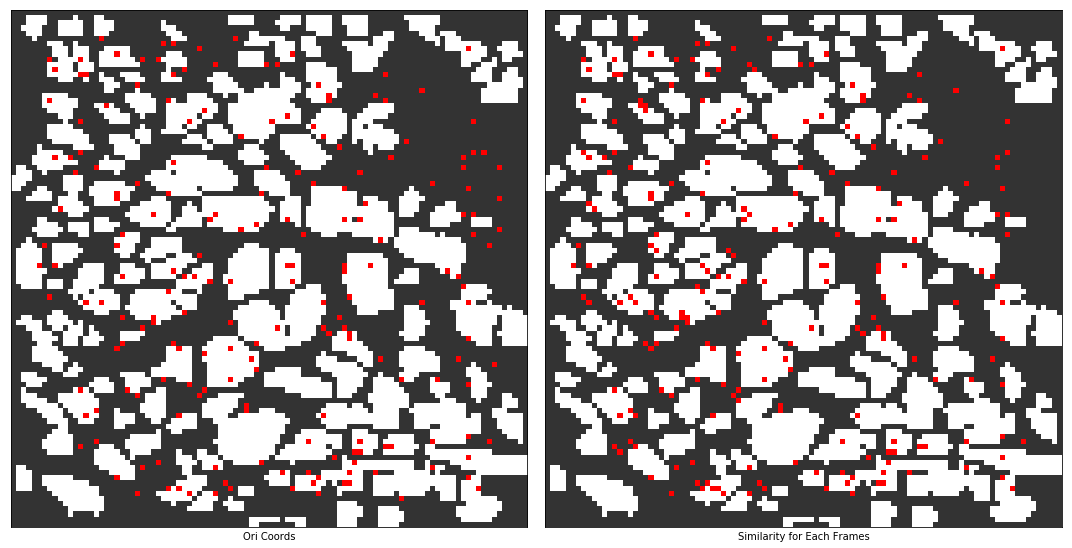

Counts:  213


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)